# Scrapping Data
### Sudoku.org.uk

In [1]:
"""In the terminal run:
conda install -n python3 -c conda-forge tqdm
tqdm: progress bar for loops
"""


'In the terminal run:\nconda install -n python3 -c conda-forge tqdm\ntqdm: progress bar for loops\n'

In [1]:
"""
Importing Libraries
"""
from bs4 import BeautifulSoup
import urllib3
import requests
import datetime
import numpy as np
import pandas as pd
from urllib.request import urlopen
from urllib.error import HTTPError
from urllib.error import URLError
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scraper import *


## FUNCTIONS

In [3]:
"""
Extract all the HTML code from the web site
in which the daily Sudoku is posted.
"""


def total_sudoku():
    r = requests.get("http://www.sudoku.org.uk/Daily.asp")
    soup = BeautifulSoup(r.content, 'html5lib')
    return(soup.find('span', attrs={'class': 'newtitle'}).get_text().split(",")[0].replace("#", ""))


### List_dates():


In [4]:
def list_dates(total):
    '''
    check if the website is working or not(for each day)
    and save this link in a list.
    Input: Website information
    Output: URL list with the websites that are running correctly
    '''
    dates = []
    dates_error = []
    urls = []
    for i in tqdm(range(2, total)):
        d = datetime.date.today() - datetime.timedelta(days=i)
        d_format = (str(d.day) + '/' + str(d.month) + '/' + str(d.year))
        URL = "http://www.sudoku.org.uk/DailySudoku.asp?solution=please&day=" + d_format
        try:
            urlopen(URL)
        except HTTPError as e:
            pass

        except URLError as e:
            pass

        else:
            urls.append(URL)
    return urls


### Get_html()

In [5]:
def get_html(url):
    '''
    Using the list of the days we're going to open each URL
    and extract all the HTML code.
    Input: url list
    Output: html code
    '''
    r = requests.get(url)
    return BeautifulSoup(r.content, 'html.parser')


### Consolidate()

In [6]:
def consolidate(urls):
    '''
    extract all the informatiom
    Input: list urls
    Output: ursl, level of difficulty, number of people
    that solved the puzzle, average time solving the puzzle
    in minutes, initial Sudoku and solution.
    '''
    solution, sudoku, level, people, av_time, unit = ([] for i in range(6))

    for url in tqdm(urls):
        a, b = ([] for i in range(2))
        soup = get_html(url)
        for link in soup.find_all(
                                'td',
                                attrs={'class': ['InnerTDone2',
                                                 'InnerTDone']}
                                ):
            if link.attrs['class'] == ['InnerTDone2']:
                b.append(link.text)
            else:
                b.append('.')
            a.append(link.text)
        sudoku.append(''.join(b))
        solution.append(''.join(a))
        p = list(list(soup.table.td)[2])
        level.append(str(p[1].get_text()).split(", ")[1].split()[0])
        people.append(str(p[3]).split()[0])
        av_time.append(str(p[3]).split()[6])
        unit.append(str(p[3]).split()[7])
    return(urls, level, people, av_time, unit, sudoku, solution)


### Extract Data

In [7]:
"""
Extract list urls
"""
urls = list_dates(pd.to_numeric(total_sudoku()))


100%|██████████| 5316/5316 [15:31<00:00,  5.71it/s]


#### However in the website says that they have 5270 puzzles (that means that the first post of a Sudoku was Feb 2006) but before March 7 of 2006 there are not registers about the players or the average time in the website, for this reason we're going to cut this urls.

In [8]:
"""
Select just the urls that have information that we need
and extract data like url, diifuclty level, people,
av_time, unit, sudoku, solution
"""
index = urls.index([x for x in urls if '=7/3/2006' in x][0])
new_urls = urls[:index]
urls, level, people, av_time, unit, sudoku, solution = consolidate(new_urls)


100%|██████████| 5075/5075 [16:09<00:00,  5.24it/s]


### Create Dataframe

In [9]:
"""
Create Dataframe with all the information scraped above
"""
df = pd.DataFrame(list(
                zip(urls, level, people, av_time, unit, sudoku, solution)),
               columns=['URL', 'Level', 'People',
                        'Average-Time', 'Unit-Time',
                        'Sudoku', 'Solution'])
print(df.shape)
df.head()


(5075, 7)


,URL,Level,People,Average-Time,Unit-Time,Sudoku,Solution
0,http://www.sudoku.org.uk/DailySudoku.asp?solut...,Tough,257,23,minutes,.3..6.7.....7.5.8..9....62.....1.8..6.93.24.1....,1352687492467951837981436254725198366593824718...
1,http://www.sudoku.org.uk/DailySudoku.asp?solut...,Moderate,269,17,minutes,6.2498...........2.1..5..9..8.7....6.9..3..7.7...,6324981579546713828172536941857294362961348757...
2,http://www.sudoku.org.uk/DailySudoku.asp?solut...,Moderate,276,14,minutes,...1.....7..9.48..3....5...21...6.3..4.....86....,4691825737519348623287654912158469379475132866...
3,http://www.sudoku.org.uk/DailySudoku.asp?solut...,Gentle,277,12,minutes,5.2...96.3...6....6.85.2.....3.418...............,5721349683918675426485927137632418594153892768...
4,http://www.sudoku.org.uk/DailySudoku.asp?solut...,Diabolical,231,31,minutes,1...6.9.3.7.2...8...3......4..1.63...3..2..4.....,1428679539752314868639547124591863276387295417...


### Create Index


In [10]:
df['Id'] = df.index
df.head()
df = df[['Id', 'Level', 'Sudoku',
         'Solution', 'People', 'Average-Time',
         'Unit-Time', 'URL']]


### Function to visualize Sudoku

In [11]:
def split(element):
    return [char for char in element]


def transform_matrix(element):
    return np.reshape(split(element), (-1, 9))


In [12]:
transform_matrix(df.Solution[4])

array([['1', '4', '2', '8', '6', '7', '9', '5', '3'],
       ['9', '7', '5', '2', '3', '1', '4', '8', '6'],
       ['8', '6', '3', '9', '5', '4', '7', '1', '2'],
       ['4', '5', '9', '1', '8', '6', '3', '2', '7'],
       ['6', '3', '8', '7', '2', '9', '5', '4', '1'],
       ['7', '2', '1', '3', '4', '5', '8', '6', '9'],
       ['5', '8', '7', '6', '9', '2', '1', '3', '4'],
       ['3', '9', '6', '4', '1', '8', '2', '7', '5'],
       ['2', '1', '4', '5', '7', '3', '6', '9', '8']], dtype='<U1')

In [13]:
transform_matrix(df.Sudoku[4])

array([['1', '.', '.', '.', '6', '.', '9', '.', '3'],
       ['.', '7', '.', '2', '.', '.', '.', '8', '.'],
       ['.', '.', '3', '.', '.', '.', '.', '.', '.'],
       ['4', '.', '.', '1', '.', '6', '3', '.', '.'],
       ['.', '3', '.', '.', '2', '.', '.', '4', '.'],
       ['.', '.', '1', '3', '.', '5', '.', '.', '9'],
       ['.', '.', '.', '.', '.', '.', '1', '.', '.'],
       ['.', '9', '.', '.', '.', '8', '.', '7', '.'],
       ['2', '.', '4', '.', '.', '.', '.', '.', '8']], dtype='<U1')

### Export Dataframe to CSV file

In [14]:
df.to_csv('data/data.csv')
df = pd.read_csv('../Omega2020/data/dataset.csv')


### Read CSV and Label the columns

In [15]:
df = df[['Id', 'Sudoku', 'Solution',
         'Level', 'People', 'Average-Time']]
df.to_csv('../Omega2020/data/dataset.csv')


# EDA (exploration Data Analysis)

In [16]:
df = pd.read_csv('../Omega2020/data/dataset.csv').drop('Unnamed: 0', axis=1)
df = df.replace({'Gentle': 'Gentle-1',
                 'Moderate': 'Moderate-2',
                 'Tough': 'Tough-3',
                 'Diabolical': 'Diabolical-4'})
print(df.shape)
df.head()


(5075, 6)


,Id,Sudoku,Solution,Level,People,Average-Time
0,0,.3..6.7.....7.5.8..9....62.....1.8..6.93.24.1....,1352687492467951837981436254725198366593824718...,Tough-3,257,23
1,1,6.2498...........2.1..5..9..8.7....6.9..3..7.7...,6324981579546713828172536941857294362961348757...,Moderate-2,269,17
2,2,...1.....7..9.48..3....5...21...6.3..4.....86....,4691825737519348623287654912158469379475132866...,Moderate-2,276,14
3,3,5.2...96.3...6....6.85.2.....3.418...............,5721349683918675426485927137632418594153892768...,Gentle-1,277,12
4,4,1...6.9.3.7.2...8...3......4..1.63...3..2..4.....,1428679539752314868639547124591863276387295417...,Diabolical-4,231,31


In [17]:
# Check that the lehgth of a Sudoku puzzle is correct
print(len(df['Sudoku'][0]))
# Check if there are Null values
df.isnull().sum()


81


Id              0
Sudoku          0
Solution        0
Level           0
People          0
Average-Time    0
dtype: int64

### Who many levels are there?

In [18]:
list(df['Level'].value_counts().index)

['Moderate-2', 'Diabolical-4', 'Tough-3', 'Gentle-1']

#### There are 4 different difficulty from the easiest to the most difficult:
##### 1. Gentle 
##### 2. Moderate 
##### 3. Tough 
##### 4. Diabolical


### QUESTION / HYPTHESIS / RESULTS

### 1) Is the number of people who solve easy puzzles greater than those who solve difficult puzzles?
#### Hypothesis: the total players in the level "Gentle" is bigger than "Diabolical" level
#### Results:

In [19]:
gb_level = df.groupby('Level', as_index=False)
gb1 = gb_level.agg({"People": "sum"}).sort_values(by='People', ascending=False)
total = gb1.People.sum()
gb1['%'] = gb1['People']/total
gb1.head()


,Level,People,%
2,Moderate-2,1704401,0.448910
0,Diabolical-4,958860,0.252547
1,Gentle-1,597057,0.157255
3,Tough-3,536437,0.141288


The hypothesis is False , more people plays diabolical than Gentle


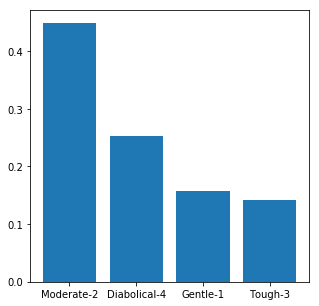

In [20]:
diabolical = gb1[gb1['Level'] == 'Diabolical-4'].values[0, 1]
gentle = gb1[gb1['Level'] == 'Gentle-1'].values[0, 1]
if gentle > diabolical:
    print('Hyphothesis is True')
else:
    print('The hypothesis is False , more people plays diabolical than Gentle')
plt.figure(figsize=(5, 5))
plt.bar(gb1['Level'], gb1['%'])
plt.show();


### 2) Does the average time in the most difficulty levels greater than the easiest?
#### Hypothesis: The average time to solve Sudoku in a "Diabolical" level is bigger than "Thought" level
#### Results:

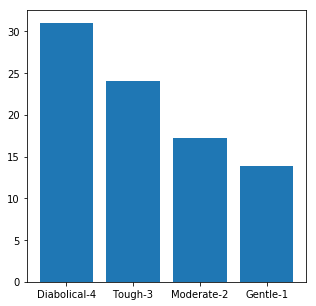

In [21]:
gb2 = gb_level.agg({"Average-Time": "mean"}).sort_values(by='Average-Time', ascending=False)
plt.figure(figsize=(5, 5))
plt.bar(gb2['Level'], gb2['Average-Time'])
plt.show();


### 3) Is the difficulty level defined by the amound of numbers given in the initial Sudoku?
#### Hypothesis: Each Level has a range of numbers given in the initial Sudoku
#### Results:

In [24]:
df['numbers_given'] = 0
for i in range(len(df)):
    df['numbers_given'][i] = sum(c.isdigit() for c in df['Sudoku'][i])
print(sum(c.isdigit() for c in df['Sudoku'][0]))
df.head()


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


28


,Id,Sudoku,Solution,Level,People,Average-Time,numbers_given
0,0,.3..6.7.....7.5.8..9....62.....1.8..6.93.24.1....,1352687492467951837981436254725198366593824718...,Tough-3,257,23,28
1,1,6.2498...........2.1..5..9..8.7....6.9..3..7.7...,6324981579546713828172536941857294362961348757...,Moderate-2,269,17,27
2,2,...1.....7..9.48..3....5...21...6.3..4.....86....,4691825737519348623287654912158469379475132866...,Moderate-2,276,14,25
3,3,5.2...96.3...6....6.85.2.....3.418...............,5721349683918675426485927137632418594153892768...,Gentle-1,277,12,28
4,4,1...6.9.3.7.2...8...3......4..1.63...3..2..4.....,1428679539752314868639547124591863276387295417...,Diabolical-4,231,31,26


In [25]:
number_gentle = df['numbers_given'][df['Level'] == 'Gentle-1'].unique()
number_moderate = df['numbers_given'][df['Level'] == 'Moderate-2'].unique()
number_tough = df['numbers_given'][df['Level'] == 'Tough-3'].unique()
number_diabolical = df['numbers_given'][df['Level'] == 'Diabolical-4'].unique()
print('Gentle: ', np.sort(number_gentle))
print('Moderate: ', np.sort(number_moderate))
print('Tough: ', np.sort(number_tough))
print('Diabolical: ', np.sort(number_diabolical))


Gentle:  [23 24 25 26 27 28 29]
Moderate:  [22 23 24 25 26 27 28 29]
Tough:  [22 23 24 25 26 27 28 29]
Diabolical:  [21 22 23 24 25 26 27 28 29]


# PREDICT difficulty level base on the position of a number

In [26]:
df['new_Sudoku'] = df['Sudoku']
for i in range(len(df['new_Sudoku'])):
    df['new_Sudoku'][i] = [int(x.replace('.','0')) for x in df['new_Sudoku'][i]]
df.head()


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Id,Sudoku,Solution,Level,People,Average-Time,numbers_given,new_Sudoku
0,0,.3..6.7.....7.5.8..9....62.....1.8..6.93.24.1....,1352687492467951837981436254725198366593824718...,Tough-3,257,23,28,"[0, 3, 0, 0, 6, 0, 7, 0, 0, 0, 0, 0, 7, 0, 5, ..."
1,1,6.2498...........2.1..5..9..8.7....6.9..3..7.7...,6324981579546713828172536941857294362961348757...,Moderate-2,269,17,27,"[6, 0, 2, 4, 9, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,...1.....7..9.48..3....5...21...6.3..4.....86....,4691825737519348623287654912158469379475132866...,Moderate-2,276,14,25,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 7, 0, 0, 9, 0, 4, ..."
3,3,5.2...96.3...6....6.85.2.....3.418...............,5721349683918675426485927137632418594153892768...,Gentle-1,277,12,28,"[5, 0, 2, 0, 0, 0, 9, 6, 0, 3, 0, 0, 0, 6, 0, ..."
4,4,1...6.9.3.7.2...8...3......4..1.63...3..2..4.....,1428679539752314868639547124591863276387295417...,Diabolical-4,231,31,26,"[1, 0, 0, 0, 6, 0, 9, 0, 3, 0, 7, 0, 2, 0, 0, ..."


In [27]:
y = df['Level']
x = df['new_Sudoku']
y = y.replace({'Gentle-1': '1',
               'Moderate-2': '2',
               'Tough-3': '3',
               'Diabolical-4': '4'})
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4060,), (4060,), (1015,), (1015,))

In [28]:
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=25, max_depth=10)
rf.fit(list(X_train), y_train)
y_pred = rf.predict(list(X_test))
accuracy_score(y_test, y_pred)


0.39901477832512317

In [29]:
lr.fit(list(X_train), y_train)
y_pred = lr.predict(list(X_test))
accuracy_score(y_test, y_pred)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.412807881773399

In [2]:
scraper()

Extracting all the dates when the website has posted a puzzle and its solution


  0%|          | 1/5076 [00:00<15:59,  5.29it/s]

Extracting urls, level, people, av_time, unit, sudoku and solution 


100%|██████████| 5076/5076 [16:07<00:00,  5.24it/s]
